# Phase resolved spectroscopy of Type C QPO toy dataset

## Loading dataset

In [1]:
import astropy
from astropy.table import Table
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, DynamicalPowerspectrum, Crossspectrum, AveragedCrossspectrum
from astropy.modeling import models, fitting
from stingray.modeling.scripts import fit_powerspectrum, fit_lorentzians, fit_crossspectrum
from scipy.stats import binned_statistic
from scipy.fftpack import fft, ifft

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
type_c = "./toy_TypeC_lightcurve.fits"

lc_fits = Table.read(type_c)
meta = lc_fits.meta
print(lc_fits.info())
print(meta)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
n_seconds = meta['NSECONDS']
n_chans = meta['DETCHANS']
lc_fits

<Table length=8192>
name  dtype   shape   unit             description           
---- ------- ------- ------ ---------------------------------
 REF float64   (50,) ct / s       Reference band light curves
  CI float64 (5, 50) ct / s Channels of interest light curves
None
OrderedDict([('N_BINS', 8192), ('DT', 0.0078125), ('DETCHANS', 5), ('CHBIN', '/Users/abbie/Documents/GitHub/gsoc18/epoch5_chbinfile.txt'), ('N_SEG', 50), ('NSECONDS', 64.0), ('INFILE', "['tlist_1.fits']"), ('OBJECT', 'GX_339-4')])


REF [50],"CI [5,50]"
ct / s,ct / s
float64,float64
1280.0 .. 896.0,256.0 .. 128.0
384.0 .. 896.0,896.0 .. 128.0
768.0 .. 640.0,640.0 .. 384.0
256.0 .. 1280.0,128.0 .. 640.0
768.0 .. 1024.0,256.0 .. 384.0
768.0 .. 896.0,384.0 .. 256.0
768.0 .. 640.0,128.0 .. 256.0
1408.0 .. 768.0,0.0 .. 256.0


In [3]:
# multiply dt to get counts
ref = np.asarray(lc_fits['REF'].T * dt, dtype=np.float64)
ci = np.asarray(lc_fits['CI'].T * dt, dtype=np.float64)
print(ref.shape, ci.shape)

# get counts in ref and ci bands
ref_counts = np.hstack(ref)
ci_counts = np.hstack(ci)
print(ref_counts.shape, ci_counts.shape)

(50, 8192) (50, 5, 8192)
(409600,) (5, 409600)


## Plotting light curve and averaged power spectrum of reference band

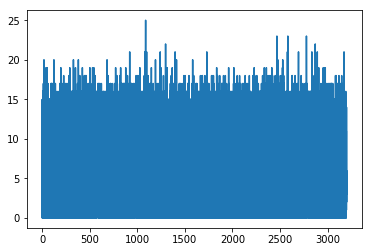

In [4]:
# rearranging reference band segments
ref_counts = np.hstack(ref)
ref_times = np.arange(0, n_seconds*n_seg, dt)

# plotting reference band lightcurve
ref_lc = Lightcurve(ref_times, ref_counts, dt=dt)
ref_lc.plot()

In [5]:
# plotting power spectrum of reference band
ref_aps = AveragedPowerspectrum(ref_lc, norm='leahy',segment_size=n_seg) # absolute normalisation

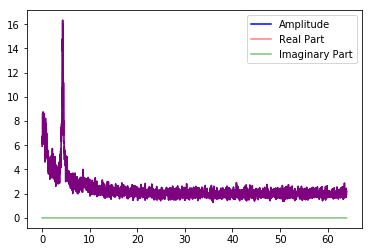

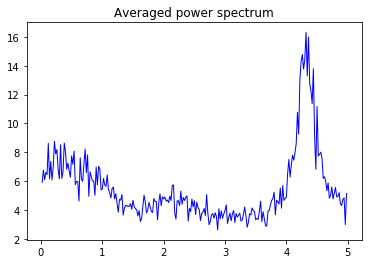

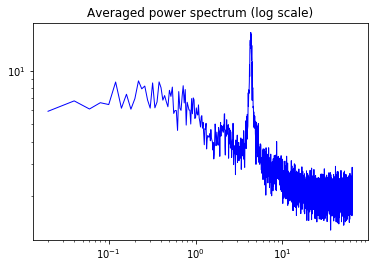

In [6]:
n = len(ref_aps.freq)
range_start, range_stop = int(0*n/64), int(5*n/64)

ref_aps.plot()

plt.figure()
plt.title("Averaged power spectrum")
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(ref_aps.power)[range_start:range_stop], lw=1, color='blue')

plt.figure()
plt.title("Averaged power spectrum (log scale)")
plt.loglog(ref_aps.freq, np.abs(ref_aps.power), lw=1, color='blue')

## Fitting Lorentzian models
1. Two lorentzians (one for each component)
2. 1 Power Law (soft?)
3. Constant

[34.63702594 -3.83703886  3.27857179]
[ 1.13775453e+01  4.33900678e+00  3.52081670e-01  3.46370259e+01
 -3.83703886e+00  3.27857179e+00 -7.83876637e-05  4.54133243e-01
  3.13437754e+00  1.94693178e+00]


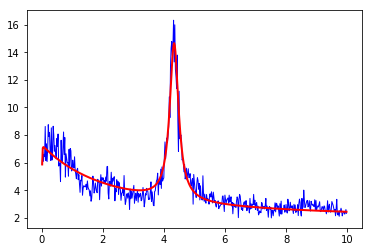

In [7]:
model_to_test = models.Lorentz1D(x_0=4.3, amplitude=12.) + models.Lorentz1D(x_0=2.) + models.PowerLaw1D() + models.Const1D()

parest, res = fit_powerspectrum(ref_aps, model_to_test)
res_model, res_pars = res.model, res.model.parameters

print(res_model[1].parameters)
print(res_pars)

n = len(ref_aps.freq)
range_start, range_stop = int(0*n/64), int(10*n/64)

plt.figure()
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(ref_aps.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(res_model(ref_aps.freq))[range_start:range_stop], lw=2, color="red")

### Determining new N

In [8]:
def nearest_power_of_2(x):
    x = int(x)
    x_lower = 1 if x == 0 else 2**(x - 2).bit_length()
    x_upper = 1 if x == 0 else 2**(x - 1).bit_length()
    return x_lower if (x - x_lower) < (x_upper - x) else x_upper

In [9]:
fwhm = res_model[0].fwhm
new_n_bins = nearest_power_of_2(1/(fwhm*dt))
new_n_seg = int(n_bins*n_seg/new_n_bins)
print("current N:", n_bins)
print("new N:", new_n_bins)
print("current M:", n_seg)
print("new M:", new_n_seg)
n_bins/new_n_bins

current N: 8192
new N: 512
current M: 50
new M: 800


16.0

800


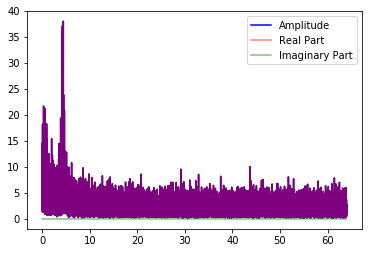

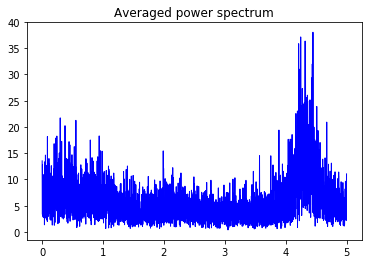

In [10]:
print(new_n_seg)
# plotting power spectrum of reference band
ref_aps_new = AveragedPowerspectrum(ref_lc, norm='leahy',segment_size=new_n_seg) # absolute normalisation

n = len(ref_aps_new.freq)
range_start, range_stop = int(0*n/64), int(5*n/64)

ref_aps_new.plot()

plt.figure()
plt.title("Averaged power spectrum")
plt.plot(ref_aps_new.freq[range_start:range_stop], (np.abs(ref_aps_new.power))[range_start:range_stop], lw=1, color='blue')


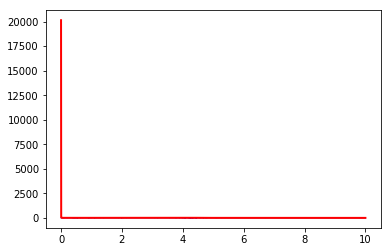

In [11]:
model_to_test = models.Lorentz1D(x_0=4.3, amplitude=12.) + models.Lorentz1D(x_0=2.) + models.PowerLaw1D() + models.Const1D()

parest, res = fit_powerspectrum(ref_aps_new, model_to_test, res_pars) # using previous params as starting params
res_model_new, res_pars_new = res.model, res.model.parameters


n = len(ref_aps_new.freq)
range_start, range_stop = int(0*n/64), int(10*n/64)

plt.figure()
plt.plot(ref_aps_new.freq[range_start:range_stop], np.abs(ref_aps_new.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(ref_aps_new.freq[range_start:range_stop], np.abs(res.mfit)[range_start:range_stop], lw=2, color="red")

In [12]:
def calculate_rms(ps, model):
    """ function to get fitting model used to calculate rms based on the type of filter used. """
    freq = ps.freq # replace this with self.freq later
    model_output = model(freq>=0) # "the integral from zero to infinity of a Lorentzian component gives the squared rms in that component"
    df = freq[1]-freq[0]
    rms = np.sqrt(np.sum(model_output * df))
    return rms

In [13]:
avg_sigma_1 = calculate_rms(ref_aps, res_model[0]) # 1st harmonic Lorentzian
avg_sigma_2 = calculate_rms(ref_aps, res_model[1]) # 2nd harmonic Lorentzian
avg_sigma_1, avg_sigma_2

(1.420495180567127, 15.109786560347526)

### Phase Difference

In [14]:
X = fft(ref_counts/dt) # fourier transform of count rate

X_1 = X[0] # 1st harmonic
X_2 = X[1] # 2nd harmonic

small_phi_1 = np.angle(X_1)
small_phi_2 = np.angle(X_2)
small_phi_1, small_phi_2, X[0], X[1]

(0.0,
 -0.17485745327529434,
 (316625536+0j),
 (985769.6781618742-174147.66623433298j))

In [15]:
cap_phi_1 = small_phi_1
cap_phi_2 = small_phi_2

In [16]:
# mean count rate
mu = np.mean(ref_counts/dt)
mu

773.0115625

# QPO Waveform

In [17]:
def wave(x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2):
    y = mu * (1 + np.sqrt(2) * (avg_sigma_1 * np.cos(x - cap_phi_1) + avg_sigma_2 * np.cos(2*x - cap_phi_2)))
    return y

In [18]:
wave_x = np.linspace(0., 2., 100)
wave_y = wave(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

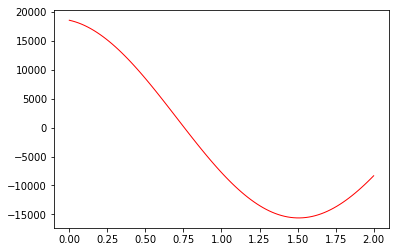

In [19]:
plt.figure()
plt.plot(wave_x, wave_y, lw=1, color='red')